## Imports

In [1]:
import numpy as np
from skimage import io
import random
import cv2 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys
from importlib import reload


from matplotlib import pyplot as plt

In [10]:
prepared_dataset = './data/mnist-noisy.h5'
dataset_seed     = 123

scale            = .1

latent_dim       = 10

train_prop       = .8
batch_size       = 128
epochs           = 4
fit_verbosity    = 1

## Base de données

### Pretraitement

found
resized


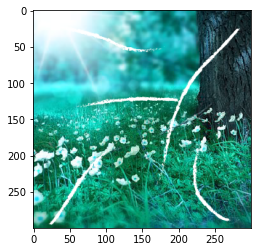

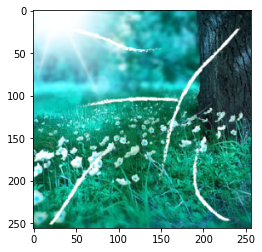

C:\Users\Albena\AppData\Local\Temp\ipykernel_25312\3684177386.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 255


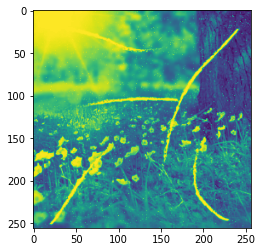

found
resized


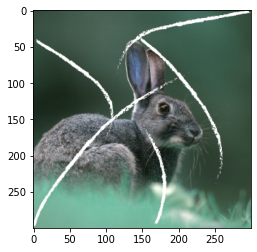

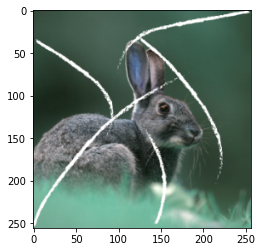

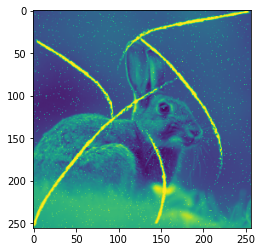

found
resized


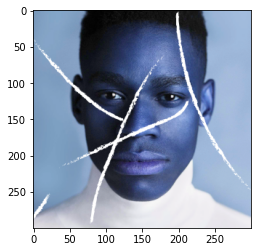

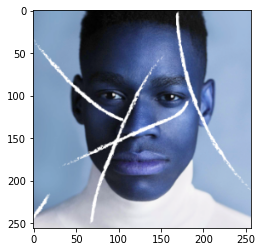

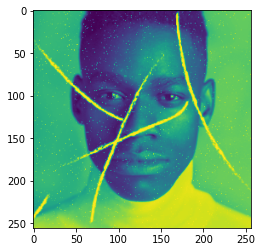

found
resized


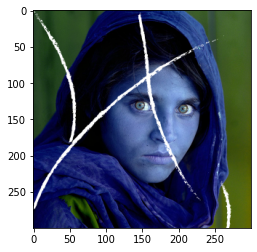

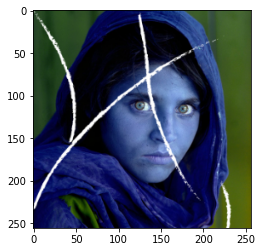

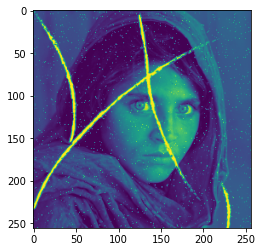

found
resized


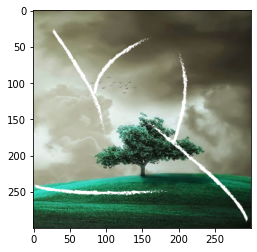

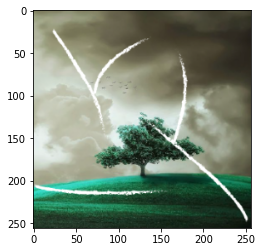

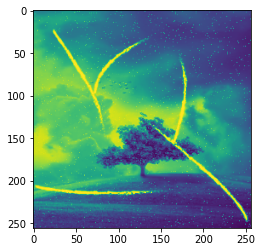

found
resized


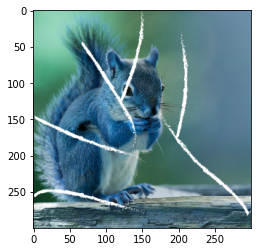

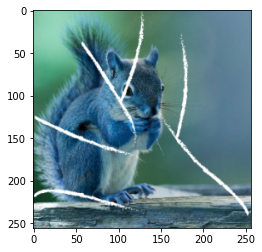

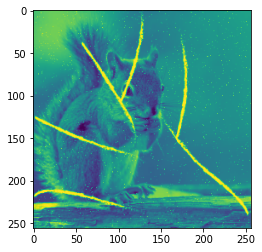

found
resized


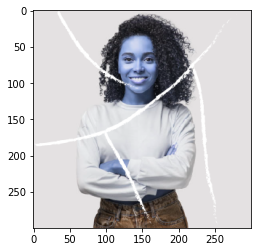

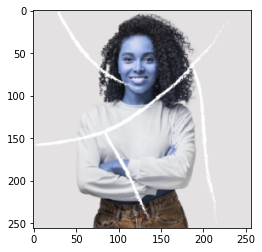

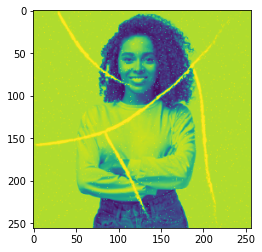

found
resized


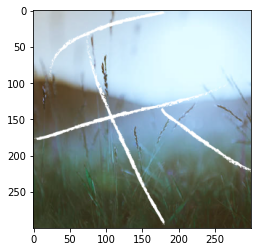

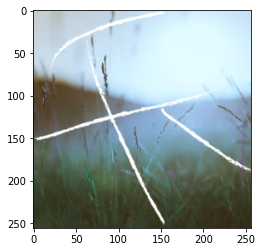

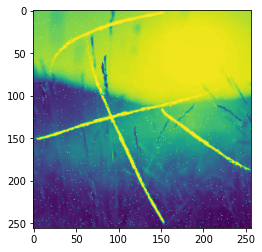

found
resized


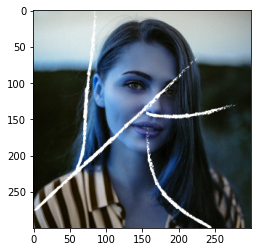

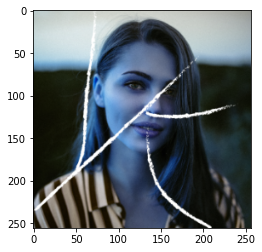

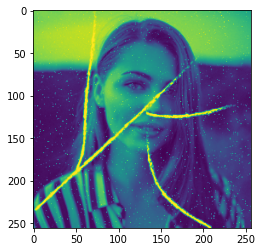

found
resized


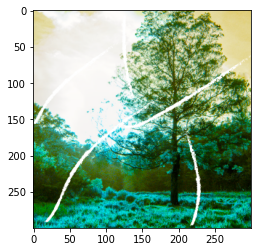

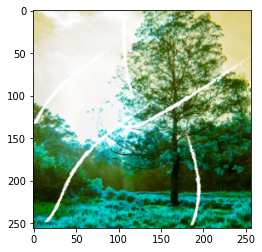

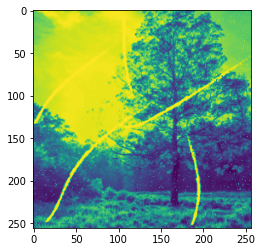

found
resized


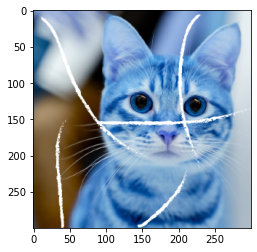

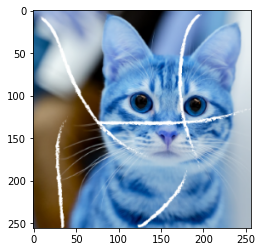

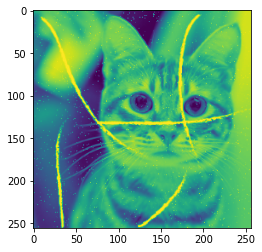

found
resized


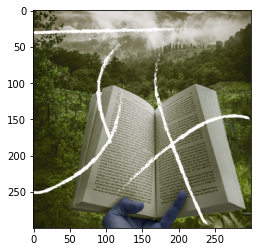

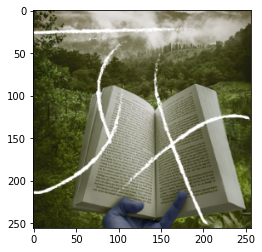

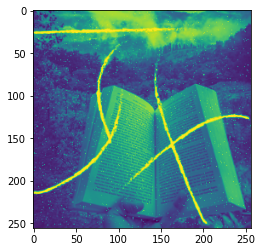

In [29]:
def add_noise_salt(image):
    row,col,ch = image.shape
    s_vs_p = 0.01
    amount = 1.0
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(image.size * s_vs_p)
    coords = [np.random.randint(0, i, int(num_salt))
          for i in image.shape]
    out[coords] = 255
    return out

def add_noise(path_src, img_size = 256):
    try:
            img = cv2.imread(path_src)
#             gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#             print("gray")
            img_y = cv2.resize(img,(img_size, img_size))
            plt.imshow(img)
            plt.show()
            plt.imshow(img_y)
            plt.show()
            degraded = add_noise_salt(img_y)
            plt.imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2GRAY))
            plt.show()
            
            return cv2.cvtColor(degraded, cv2.COLOR_BGR2GRAY)
    except Exception as e: 
            print(e)
            return None
        
def add_noise_to_images(path_src, path_dst):
    for img_name in os.listdir(path_src):
        img = add_noise(path_src + '/' + img_name, 256)
        cv2.imwrite(path_dst + '/1' + img_name, img)
        
        
add_noise_to_images("images/degraded","images/degraded2" )

In [2]:
IMG_SIZE = 28
training_data = []
def create_training_data(path_X, path_y):
    X  = []
    y = []
    for img in os.listdir(path_X):
        img_array = cv2.imread(os.path.join(path_X,img))
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        X.append(new_array)
    for img in os.listdir(path_y):
        img_array = cv2.imread(os.path.join(path_y,img))
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        y.append(new_array)
    return X, y
        
X, y = create_training_data("images/degraded2", "images/originals")
# print(training_data)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# for image in y:
#     ksize = (10, 10)
#     image = cv2.blur(image, ksize)
    
# y = np.array(y).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [4]:
clean_train,clean_test, noisy_train,noisy_test = y, y, X, X
print(noisy_train.shape)

(36, 28, 28, 1)


## Modele

#### Encoder

In [9]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                50192     
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 69,042
Trainable params: 69,042
Non-trainable

#### Decoder

In [7]:
latent_dim = 2
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

#### AE


In [10]:
inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name="ae")

ae.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')

## Entrainement

In [13]:
batch_size = 4
epochs = 4
fit_verbosity = 2

history = ae.fit(noisy_train, clean_train,
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = fit_verbosity,
                 validation_data = (noisy_test, clean_test)  )


Epoch 1/4
9/9 - 1s - loss: -2.6806e+02 - val_loss: -2.0144e+03 - 1s/epoch - 159ms/step
Epoch 2/4
9/9 - 0s - loss: -1.7227e+04 - val_loss: -7.1371e+04 - 154ms/epoch - 17ms/step
Epoch 3/4
9/9 - 0s - loss: -4.4305e+05 - val_loss: -1.1781e+06 - 121ms/epoch - 13ms/step
Epoch 4/4
9/9 - 0s - loss: -4.4600e+06 - val_loss: -1.2089e+07 - 125ms/epoch - 14ms/step


## Resultats (Prediction)

2/2 [==============================] - 0s 4ms/step


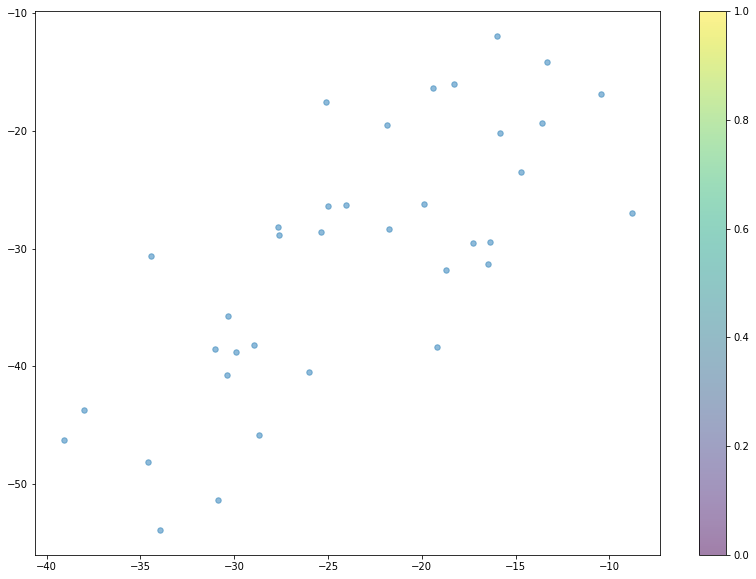

In [101]:
model = ae
encoder=model.get_layer('encoder')


# ---- Get latent points

z = encoder.predict(X)

# ---- Show them

fig = plt.figure(figsize=(14, 10))
plt.scatter(z[:, 0] , z[:, 1], cmap= 'tab10', alpha=0.5, s=30)
plt.colorbar()
# fidle.scrawler.save_fig('08-Latent-space')
plt.show()

2/2 - 0s - 37ms/epoch - 19ms/step
(1, 28, 28, 1)


TypeError: Invalid shape (36, 28, 28, 1) for image data

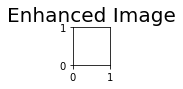

In [107]:
to_predict = np.array(X[0]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
denoise = model.predict(X,verbose=2)
print(to_predict.shape)
# im_reshaped = np.reshape(denoise, [-1,28,28,3])

plt.subplot(5,5,1)
img_ = denoise
img_[:,:,:] = denoise[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

for img in denoise:
    plt.imshow(img)
    plt.show()
plt.show()